In [1]:
import numpy as np
from sklearn.preprocessing import PolynomialFeatures
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import ElasticNet
import joblib

import matplotlib.pyplot as plt

from Model.Parabola import Parabola
from Model.Hyperbola import Hyperbola
from Model.Circular import Circular
from Model.RayPath import RayPath

In [2]:
# this is very simple eye model
# cornea is modeled as a circle
# crystal is considred as a thin layer that focus the light perfectly like a meta lens
# retina is modeled as a circle

# Define the parameters of the eye [mm]
Eye_Params = {
    'eye_radius': 11,
    'pupil_radius': 2,
    'iris_radius': 5,
    'FOV_Ratio': 0.3
}
iris_depth = np.sqrt(Eye_Params['eye_radius']**2 - Eye_Params['iris_radius']**2)
Eye_Params['iris_depth'] = iris_depth
Retina = Circular(np.array([-Eye_Params['eye_radius']-iris_depth, 0]), np.array([0, -1]), -0.9*Eye_Params['eye_radius'], 0.9*Eye_Params['eye_radius'])
Retina.set_params(Eye_Params['eye_radius'], 1)
Retina_plot = Retina.get_pos(100)

In [3]:
def calc_hit_retina(Retina, ray_origin, ray_direction):
    origin_obj = np.matmul(Retina.rot, ray_origin - Retina.origin)
    direction_obj = np.matmul(Retina.rot, ray_direction)
    pos_obj, tan_obj = RayPath().intersection(Retina, origin_obj, direction_obj)
    if len(pos_obj) < 2 or len(tan_obj) < 2:
        return [], []
    ray_hit_pos = np.matmul(Retina.rot.T, pos_obj.T) + Retina.origin
    ray_hit_tangent = np.matmul(Retina.rot.T, tan_obj.T)
    return ray_hit_pos, ray_hit_tangent



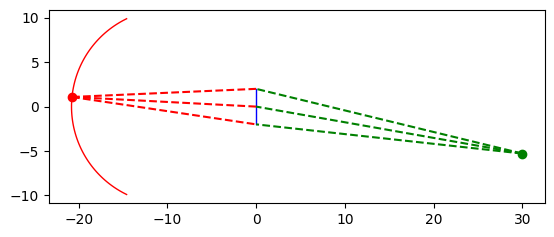

In [4]:

lens_y = np.linspace(-Eye_Params['pupil_radius'], Eye_Params['pupil_radius'], 3)
lens_x = np.zeros_like(lens_y)
lens_pos = np.array([lens_x, lens_y])

Object_dpeth = 30 # distance of the object from the eye [mm]
theta = -10*np.pi/180 # angle of the object [radians]
theta_eye = theta*Eye_Params['FOV_Ratio']
ray_origin = np.array([0, 0])
ray_direction = np.array([-np.cos(theta_eye), -np.sin(theta_eye)])
ray_hit_pos, ray_hit_tangent = calc_hit_retina(Retina, ray_origin, ray_direction)
Object_x = Object_dpeth # distance of the object from the eye [mm]
Object_y = Object_dpeth*np.tan(theta) # distance of the object from the eye [mm]
angle_retina = np.arctan2((lens_y - ray_hit_pos[1]), (lens_x - ray_hit_pos[0]))
angle_object = np.arctan2((Object_y - lens_y), (Object_x - lens_x))



plt.plot(Retina_plot[0], Retina_plot[1], 'r', linewidth=1)
plt.plot(lens_x, lens_y, 'b', linewidth=1)
plt.plot(ray_hit_pos[0], ray_hit_pos[1], 'ro')
plt.plot(Object_x, Object_y, 'go')
plt.plot([ray_hit_pos[0]*np.ones_like(lens_x), lens_x], [ray_hit_pos[1]*np.ones_like(lens_x), lens_y], 'r--')
plt.plot([Object_x*np.ones_like(lens_x), lens_x], [Object_y*np.ones_like(lens_x), lens_y], 'g--')
plt.gca().set_aspect(1)
plt.show()




In [5]:

lens_y = np.linspace(-Eye_Params['pupil_radius'], Eye_Params['pupil_radius'], 51)
lens_x = np.zeros_like(lens_y)
lens_pos = np.array([lens_x, lens_y])


FOV = 150 # field of view [degrees]
Object_dpeth = 150 # distance of the object from the eye [mm]

FOV_theta = FOV*np.pi/180*np.linspace(-0.5, 0.5, 51)
INPUT_y = np.tile(lens_y, (len(FOV_theta), 1))
INPUT_angle = []
OUPUT_angle = []
for theta in FOV_theta:
    theta_eye = theta*Eye_Params['FOV_Ratio']
    ray_origin = np.array([0, 0])
    ray_direction = np.array([-np.cos(theta_eye), -np.sin(theta_eye)])
    ray_hit_pos, ray_hit_tangent = calc_hit_retina(Retina, ray_origin, ray_direction)

    if len(ray_hit_pos) < 2 or len(ray_hit_tangent) < 2:
        # Skip the following code
        pass
    else:
        # angle of ray from lens to retina
        angle_retina = np.arctan2((lens_y - ray_hit_pos[1]), (lens_x - ray_hit_pos[0]))
        # angle of the object from the lens
        Object_x = Object_dpeth # distance of the object from the eye [mm]
        Object_y = Object_dpeth*np.tan(theta) # distance of the object from the eye [mm]
        angle_object = np.arctan2((Object_y - lens_y), (Object_x - lens_x))
        #
        INPUT_angle.append(angle_object)
        OUPUT_angle.append(angle_retina)

INPUT_angle = np.array(INPUT_angle)
OUPUT_angle = np.array(OUPUT_angle)

INPUT = [INPUT_y.flatten(), INPUT_angle.flatten()]
OUTPUT = OUPUT_angle.flatten()



Mean absolute error: -7.584496489353422e-18
Mean relative error: 7.104330847998845e-05
Coefficients: [ 0.00000000e+00  4.99258911e-02  3.00011981e-01 -2.39075477e-17
  6.96851911e-17  8.96929130e-18 -3.31082015e-05 -7.06961693e-04
 -1.38497385e-03 -1.32314042e-05]
Intercept: 6.440482025762956e-17


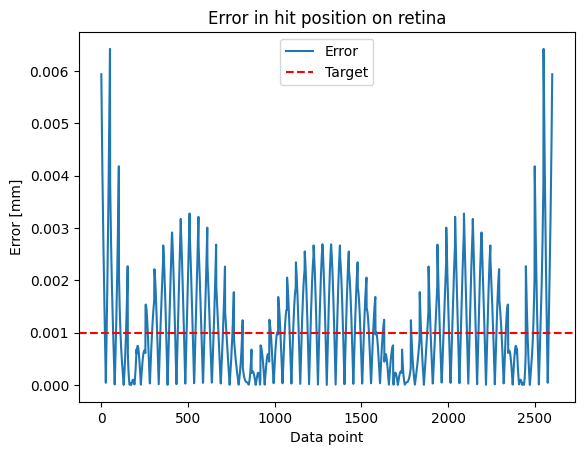

In [6]:
 
# Define the input and output data
X = np.array(INPUT).T  # Transpose the input
y = np.array(OUTPUT)

# Transform the input data to polynomial features
degree = 3  # You can change this to any integer greater than 1
poly = PolynomialFeatures(degree)
X_poly = poly.fit_transform(X)

# Create a linear regression model
model = LinearRegression()
# model = ElasticNet()

# Fit the model to the polynomial features
model.fit(X_poly, y)

# save the model to disk
filename = 'eye_model.joblib'
# Create a dictionary to save the model and PolynomialFeatures object
# model_dict = {"Eye_Params": Eye_Params, "FOV": FOV, "Focus_depth": Object_dpeth, "model": model, "poly": X_poly}
model_dict = {"Eye_Params": Eye_Params, "FOV": FOV, "Focus_depth": Object_dpeth, "model": model, "poly": poly}

# Save the dictionary as a pickle file. If exists, it will be overwritten
joblib.dump(model_dict, filename)

# Load the dictionary from the pickle file
loaded_dict = joblib.load(filename)

# Extract the model and PolynomialFeatures object from the dictionary
model = loaded_dict["model"]
# X_poly = loaded_dict["poly"]
poly = loaded_dict["poly"]
X_poly = poly.fit_transform(X)
# Predict the output for new input data
output_predicted = model.predict(X_poly)

# Absolute error
absolute_error = output_predicted - OUTPUT
print("Mean absolute error:", np.mean(absolute_error))

# Relative error
relative_error = (output_predicted - OUTPUT)/(OUTPUT + 1e-9)
print("Mean relative error:", np.mean(relative_error))

# Print the coefficients and intercept of the linear regression model
print("Coefficients:", model.coef_)
print("Intercept:", model.intercept_)

# plot error in hit position on retina
plt.plot(np.sqrt(2 - 2*np.cos(absolute_error))*Eye_Params['eye_radius'])
# target error is 0.001 mm (2 time the diameter of cone cell)
plt.axhline(y=0.001, color='r', linestyle='--')
# title and labels and legend
plt.title('Error in hit position on retina')
plt.xlabel('Data point')
plt.ylabel('Error [mm]')
plt.legend(['Error', 'Target'])
# show plot
plt.show()



In [ ]:
# validation
lens_y = np.linspace(-Eye_Params['pupil_radius'], Eye_Params['pupil_radius'], 101)
lens_x = np.zeros_like(lens_y)
FOV_theta = FOV*np.pi/180*np.linspace(-0.49, 0.49, 101)
INPUT_angle = []
OUPUT_angle = []
for theta in FOV_theta:
    theta_eye = theta*Eye_Params['FOV_Ratio']
    ray_origin = np.array([0, 0])
    ray_direction = np.array([-np.cos(theta_eye), -np.sin(theta_eye)])
    ray_hit_pos, ray_hit_tangent = calc_hit_retina(Retina, ray_origin, ray_direction)
    if len(ray_hit_pos) < 2 or len(ray_hit_tangent) < 2:
        # Skip the following code
        pass
    else:
        # angle of ray from lens to retina
        angle_retina = np.arctan2((lens_y - ray_hit_pos[1]), (lens_x - ray_hit_pos[0]))
        # angle of the object from the lens
        Object_x = Object_dpeth # distance of the object from the eye [mm]
        Object_y = Object_dpeth*np.tan(theta) # distance of the object from the eye [mm]
        angle_object = np.arctan2((Object_y - lens_y), (Object_x - lens_x))
        #
        INPUT_angle.append(angle_object)
        OUPUT_angle.append(angle_retina)
INPUT_angle = np.array(INPUT_angle)
INPUT_y = np.tile(lens_y, (len(FOV_theta), 1))
output_true = np.array(OUPUT_angle).flatten()

# Predict the output for new input data
# Transform the input data to polynomial features
INPUT = [INPUT_y.flatten(), INPUT_angle.flatten()]
X = np.array(INPUT).T
X_poly = poly.fit_transform(X)
output_predicted = model.predict(X_poly)

# Absolute error
absolute_error = output_predicted - output_true
print("Mean absolute error:", np.mean(absolute_error))

# Relative error
relative_error = (output_predicted - output_true)/(output_true + 1e-9)
print("Mean relative error:", np.mean(relative_error))

# histogram of error
plt.hist(absolute_error, bins=100)
# y axis in log scale
plt.yscale('log')
# title and labels and legend
plt.title('Error in hit position on retina')
plt.xlabel('Error [radians]')
plt.ylabel('Frequency')
# show plot
plt.show()